# Validation experiments
_Author: Bart van Erp_ 

_Date:   02-05-2022_

This notebook contains the validation experiments to the paper **Modular Model-Based Online Source Separation using Non-Linear Autoregressive Models**.

## Load packages

In [1]:
using Revise
using SourceSeparationINN
using LinearAlgebra, Random, Distributions
using HDF5, JLD2
using PyPlot

BLAS.set_num_threads(1)
Random.seed!(1234);

## Load data

In [2]:
# load data
data_train_signal = Data("../../../../../data/speech/train/processed/" .* readdir("../../../../../data/speech/train/processed"), Float64)
data_test_signal = Data("../../../../../data/speech/test/processed/" .* readdir("../../../../../data/speech/test/processed"), Float64);
data_train_noise = Data("../../../../../data/noise/airco/train/processed/" .* readdir("../../../../../data/noise/airco/train/processed"), Float64)
data_test_noise = Data("../../../../../data/noise/airco/test/processed/" .* readdir("../../../../../data/noise/airco/test/processed"), Float64);

In [3]:
# generate data if it does not exist yet
if !isdir("data")

    # create folders
    mkdir("data")
    mkdir("data/test")
    mkdir("data/test/mix")

    # generate test data
    for k = 1:minimum([length(data_test_signal), length(data_test_noise)])
        len = minimum([length(data_test_signal[k]), length(data_test_noise[k])])
        h5write(string("data/test/mix/",    lpad(k,4,"0"), ".h5"), "signal", data_test_signal[k][1:len] + data_test_noise[k][1:len])
    end

end

# load data
data_test_mix    = Data("data/test/mix/"    .* readdir("data/test/mix"),    Float64);

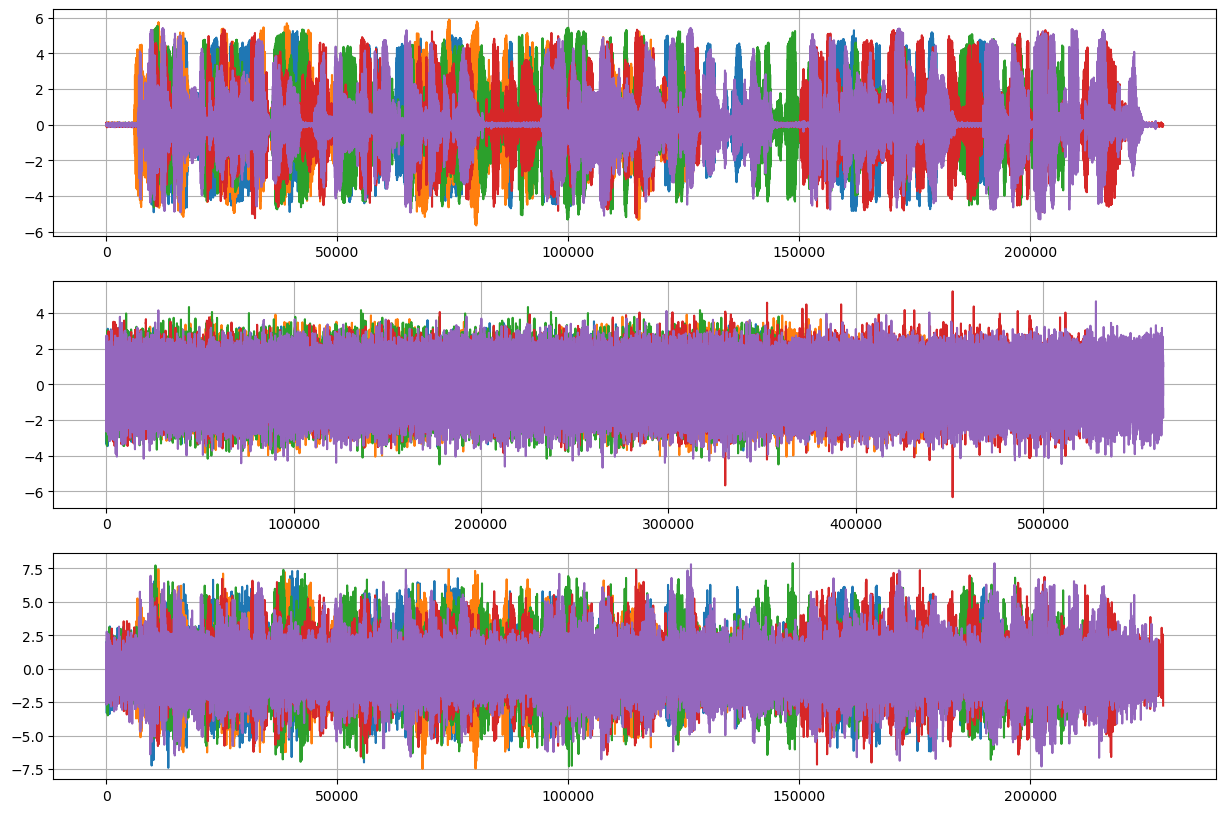

In [4]:
_, ax = plt.subplots(figsize=(15,10), nrows=3)
for k in 1:5
    ax[1].plot(data_test_signal[k])
    ax[2].plot(data_test_noise[k])
    ax[3].plot(data_test_mix[k])
end
 ax[1].grid(), ax[2].grid(), ax[3].grid();

## Train models

In [5]:
function create_NAR_model(dim; shift=1, batch_size::Int=128)

    return SourceSeparationINN.Model(
        dim,
        (
            ARLayer(
                dim,
                SourceSeparationINN.Model(  
                    dim-shift,
                    shift,
                    (   
                        DenseLayer(dim-shift, 16; batch_size=batch_size, optimizer=Adam),
                        LeakyReluLayer(16; batch_size=batch_size),
                        DenseLayer(16, 16; batch_size=batch_size, optimizer=Adam),
                        LeakyReluLayer(16; batch_size=batch_size),
                        DenseLayer(16, shift; batch_size=batch_size, optimizer=Adam),
                    );
                    batch_size=batch_size
                );
                batch_size=batch_size
            ),
        );
        batch_size=batch_size
    )
        
end
batch_size = 16
dim_in = 16
loss_function_signal = MSE(batch_size=batch_size)
loss_function_noise  = MSE(batch_size=batch_size)
;

In [6]:
# load/train signal model
if isdir("logs/signal")

    # load model
    model_signal = load(string("logs/signal/", readdir("logs/signal")[1], "/model.jld2"))["model"]

else

    # create model
    model_signal = create_NAR_model(dim_in; batch_size=batch_size)

    # set learning rate
    # setlr!(model_signal, 1e-5)

    # create train suite
    train_suite_signal = TrainSuite(
        model_signal,           # model
        loss_function_signal,   # loss function
        data_train_signal,      # train data
        data_test_signal,       # test data
        1,                     # number of epochs
        "logs/signal/"          # path to log directory
    );

    # create folder
    mkdir("logs/signal")

    # train model
    run!(train_suite_signal)

end;

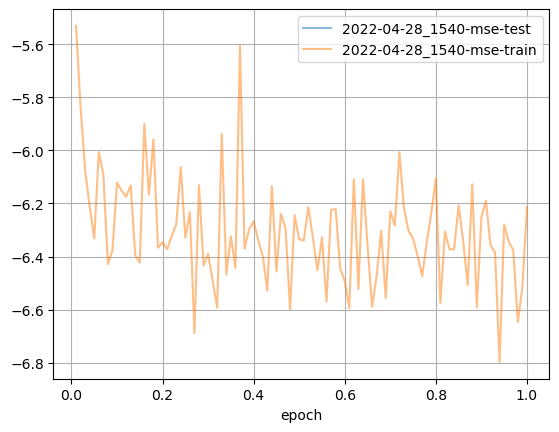

In [7]:
# plot loss function over training duration
plot_logs(; path="logs/signal/", logscale=true);

In [8]:
# load/train noise model
if isdir("logs/noise")

    # load model
    model_noise = load(string("logs/noise/", readdir("logs/noise")[1], "/model.jld2"))["model"]

else

    # create model
    model_noise = create_NAR_model(dim_in; batch_size=batch_size)

    # set learning rate
    # setlr!(model_noise, 1e-5)

    # create train suite
    train_suite_noise = TrainSuite(
        model_noise,           # model
        loss_function_noise,   # loss function
        data_train_noise,      # train data
        data_test_noise,       # test data
        5,                    # number of epochs
        "logs/noise/"          # path to log directory
    );

    # create folder
    mkdir("logs/noise")

    # train model
    run!(train_suite_noise)

end;

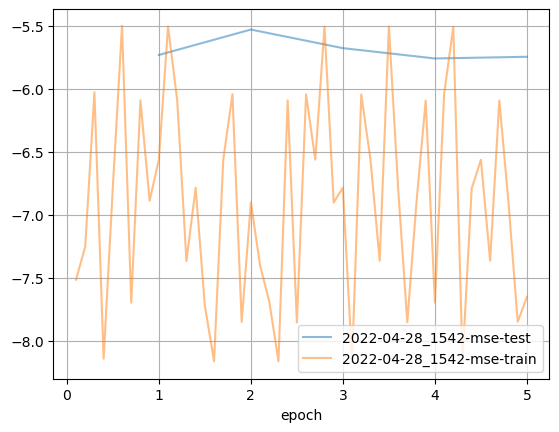

In [9]:
# plot loss function over training duration
plot_logs(; path="logs/noise/", logscale=true);

# Model specification

In [10]:
using ReactiveMP, GraphPPL, Rocket
include("../../../../verification/reactivemp/reactivemp_extension.jl")

In [11]:
@model function observation_model(gs, gn, Hs, Hn, Qs, Qn, R)

    # specify data variables
    μ_s = datavar(Vector{Float64})
    μ_n = datavar(Vector{Float64})
    Σ_s = datavar(Matrix{Float64})
    Σ_n = datavar(Matrix{Float64})

    # specify priors
    s_prev ~ MvNormalMeanCovariance(μ_s, Σ_s)
    n_prev ~ MvNormalMeanCovariance(μ_n, Σ_n)

    # propagate priors through non-linearities
    s_trans ~ Nar(s_prev) where { meta = NarMeta(gs, Linearization()) }
    n_trans ~ Nar(n_prev) where { meta = NarMeta(gn, Linearization()) }

    # add process noise
    s ~ MvNormalMeanCovariance(s_trans, Qs)
    n ~ MvNormalMeanCovariance(n_trans, Qn)

    # form observation
    y = datavar(Float64)
    y ~ NormalMeanVariance(dot(Hs, s) + dot(Hn, n), R)

    # return variables
    return μ_s, μ_n, Σ_s, Σ_n, y, s, n

end

observation_model (generic function with 1 method)

## Specify priors

In [12]:
# specify observation model
Hs = zeros(dim_in)
Hs[1] = 1
Hn = zeros(dim_in)
Hn[1] = 1

# specify process noise 
Qs = zeros(dim_in, dim_in)
Qs[1,1] = exp(-6.4) * dim_in
Qn = zeros(dim_in, dim_in)
Qn[1,1] = exp(-5.5) * dim_in

# specify observation noise
R = 1e-10

# select signal
signal_mix = data_test_mix[1]

# set priors for underlying signals
m_s_prior = randn(dim_in)
V_s_prior = 1e2*diagm(ones(dim_in));
m_n_prior = randn(dim_in)
V_n_prior = 1e2*diagm(ones(dim_in));

# Perform inference

In [13]:
using ProgressMeter

In [14]:
function inference_Nar(data_y, Hs, Hn, Qs, Qn, R, ms, Vs, mn, Vn, gs, gn; progress=true)

    # fetch number of samples
    nr_samples = length(data_y)

    # create model
    model, (μ_s, μ_n, Σ_s, Σ_n, y, s, n) = observation_model(gs, gn, Hs, Hn, Qs, Qn, R)

    # allocate output
    separated_s = Vector{NormalMeanVariance}(undef, nr_samples)
    separated_n = Vector{NormalMeanVariance}(undef, nr_samples)

    # initialize buffers
    marg_s = keep(Marginal)
    marg_n = keep(Marginal)

    # subscribe to marginals
    s_sub = subscribe!(getmarginal(s), marg_s)
    n_sub = subscribe!(getmarginal(n), marg_n)
    
    # set priors
    μ_s_prior = copy(ms)
    Σ_s_prior = copy(Vs)
    μ_n_prior = copy(mn)
    Σ_n_prior = copy(Vn)

    # create optional progress bar
    p = Progress(nr_samples; enabled=progress)

    # loop through data
    for k in 1:nr_samples

        # update priors
        ReactiveMP.update!(μ_s, μ_s_prior)
        ReactiveMP.update!(Σ_s, Σ_s_prior)
        ReactiveMP.update!(μ_n, μ_n_prior)
        ReactiveMP.update!(Σ_n, Σ_n_prior)

        # update observation
        ReactiveMP.update!(y, data_y[k])

        # extract marginals
        μ_s_prior, Σ_s_prior = mean_cov(getvalues(marg_s)[end])
        μ_n_prior, Σ_n_prior = mean_cov(getvalues(marg_n)[end])

        # save marginals
        separated_s[k] = NormalMeanVariance(μ_s_prior[1], Σ_s_prior[1,1])
        separated_n[k] = NormalMeanVariance(μ_n_prior[1], Σ_n_prior[1,1])

        # update progress meter
        if progress
            ProgressMeter.next!(p)
        end

    end

    # unsubscribe
    unsubscribe!([s_sub, n_sub])

    # return values
    return separated_s, separated_n

end

inference_Nar (generic function with 1 method)

In [15]:
deployed_model_signal = deploy(model_signal)
deployed_model_noise = deploy(model_noise);

# Plot first results

In [16]:
separated_s, separated_n = inference_Nar(signal_mix, Hs, Hn, Qs, Qn, R, m_s_prior, V_s_prior, m_n_prior, V_n_prior, deployed_model_signal, deployed_model_noise);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:168:59m


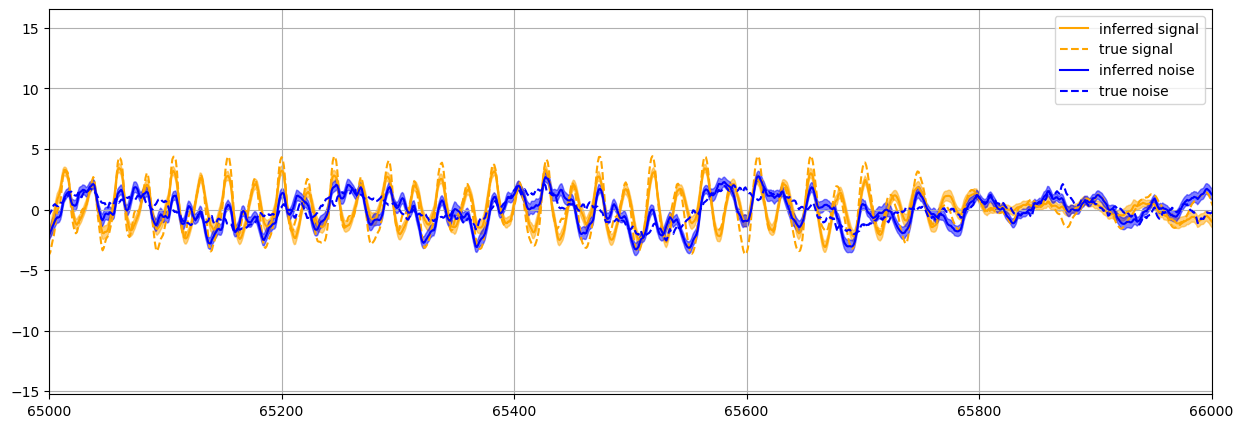

(65000.0, 66000.0)

In [17]:
plt.figure(figsize=(15,5))
plt.fill_between(1:length(separated_s), mean.(separated_s) .- std.(separated_s), mean.(separated_s) .+ std.(separated_s) , color="orange", alpha=0.5)
plt.plot(1:length(separated_s), mean.(separated_s), color="orange", label="inferred signal")
plt.plot(1:length(data_test_signal[1]), data_test_signal[1], color="orange", linestyle="--", label="true signal")
plt.fill_between(1:length(separated_n), mean.(separated_n) .- std.(separated_n), mean.(separated_n) .+ std.(separated_n), color="blue", alpha=0.5)
plt.plot(1:length(separated_n), mean.(separated_n), color="blue", label="inferred noise")
plt.plot(1:length(data_test_noise[1]), data_test_noise[1], color="blue", linestyle="--", label="true noise")
plt.grid()
plt.legend()
# plt.ylim(-5,5)
plt.xlim(65000,66000)

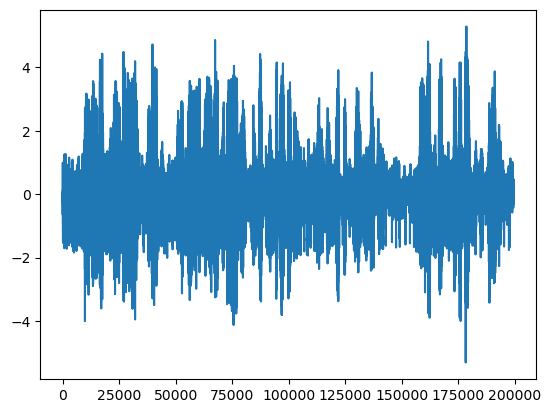

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000013EA8FF70>

In [18]:
plt.plot(mean.(separated_s))

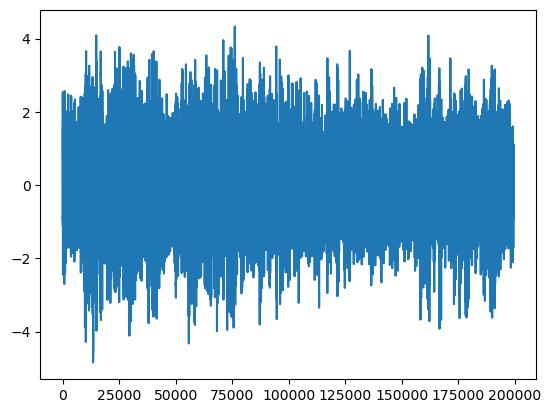

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000000745B760>

In [19]:
plt.plot(mean.(separated_n))

## Compute performance metrics

In [20]:
using WAV
if !isfile("exports/metrics.h5")
    
    MSE_filtering  = Vector{Float64}(undef, length(data_test_mix))
    MAE_filtering  = Vector{Float64}(undef, length(data_test_mix))
    logp_filtering = Vector{Float64}(undef, length(data_test_mix))
    SNR_filtering  = Vector{Float64}(undef, length(data_test_mix))

    @showprogress for (ind, signal_mix) in enumerate(data_test_mix)

        # run source separation inference
        separated_s, separated_n = inference_Nar(signal_mix, Hs, Hn, Qs, Qn, R, m_s_prior, V_s_prior, m_n_prior, V_n_prior, deployed_model_signal, deployed_model_noise; progress=false);

        # calculate metrics
        MSE_filtering[ind]  = mean(abs2.(mean.(separated_s) - data_test_signal[ind]))
        MAE_filtering[ind]  = mean(abs.(mean.(separated_s) - data_test_signal[ind]))
        logp_filtering[ind] = mean([logpdf(Normal(mean(separated_s[k]), std(separated_s[k])), data_test_signal[ind][k]) for k=1:length(separated_s)])
        SNR_filtering[ind]  = 10*log10(mean(abs2.(data_test_signal[ind])) / mean(abs2.(mean.(separated_s) - data_test_signal[ind])))

        # save files
        wavwrite(mean.(separated_s), string("exports/signal_inferred_", lpad(ind,4,"0"), ".wav"), Fs=16000)
        wavwrite(data_test_signal[ind], string("exports/signal_true_", lpad(ind,4,"0"), ".wav"), Fs=16000)
        wavwrite(data_test_mix[ind], string("exports/mix_", lpad(ind,4,"0"), ".wav"), Fs=16000)
        
    end

    # save metrics
    h5write("exports/metrics.h5", "MSE",  MSE_filtering)
    h5write("exports/metrics.h5", "MAE",  MAE_filtering)
    h5write("exports/metrics.h5", "logp", logp_filtering)
    h5write("exports/metrics.h5", "SNR",  SNR_filtering)

else

    # load metrics
    MSE_filtering = h5read("exports/metrics.h5", "MSE")
    MAE_filtering = h5read("exports/metrics.h5", "MAE")
    logp_filtering = h5read("exports/metrics.h5", "logp")
    SNR_filtering = h5read("exports/metrics.h5", "SNR")

end;

Progress: 100%|█████████████████████████████████████████| Time: 0:33:04


In [21]:
mean(MSE_filtering), mean(MAE_filtering), mean(logp_filtering), mean(SNR_filtering)

(0.5002970432395636, 0.5237196385849995, -1.558636849218392, 3.0455303475224236)

## Median MSE situation

In [22]:
# fetch index of median MSE
ind = argmin(abs.(MSE_filtering .- median(MSE_filtering)))

3

In [23]:
separated_s, separated_n = inference_Nar(data_test_mix[ind], Hs, Hn, Qs, Qn, R, m_s_prior, V_s_prior, m_n_prior, V_n_prior, deployed_model_signal, deployed_model_noise);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


In [24]:
min_length = minimum([length(data_test_signal[ind]), length(data_test_noise[ind])])
save(
    "exports/separated_signals.jld2",
    "signal", separated_s,
    "noise", separated_n,
    "signal_true", data_test_signal[ind][1:min_length],
    "noise_true", data_test_noise[ind][1:min_length]
)

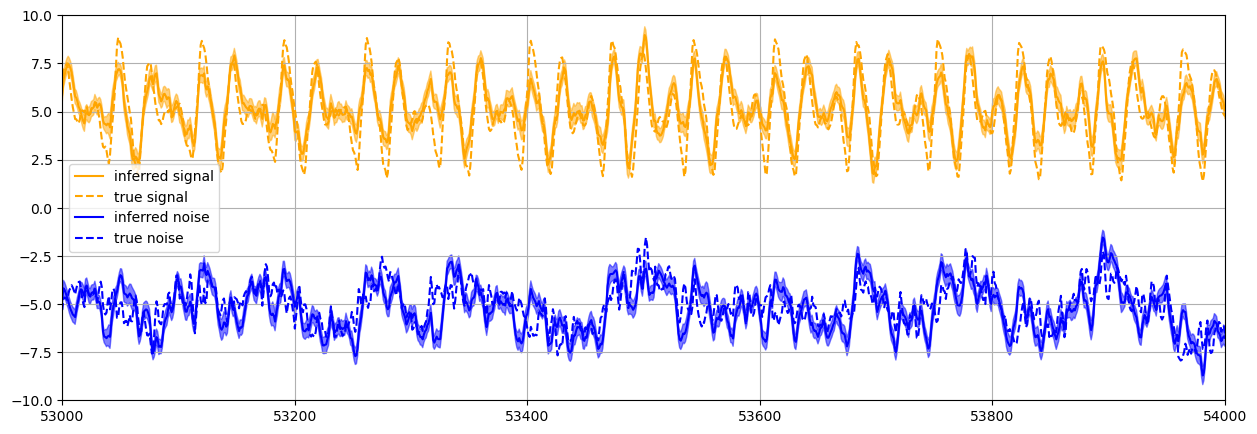

(53000.0, 54000.0)

In [25]:
plt.figure(figsize=(15,5))
plt.fill_between(1:length(separated_s), mean.(separated_s) .- std.(separated_s) .+5, mean.(separated_s) .+ std.(separated_s).+5 , color="orange", alpha=0.5)
plt.plot(1:length(separated_s), mean.(separated_s).+5, color="orange", label="inferred signal")
plt.plot(1:length(separated_s), data_test_signal[ind][1:min_length].+5, color="orange", linestyle="--", label="true signal")
plt.fill_between(1:length(separated_n), mean.(separated_n) .- std.(separated_n).-5, mean.(separated_n) .+ std.(separated_n).-5, color="blue", alpha=0.5)
plt.plot(1:length(separated_n), mean.(separated_n).-5, color="blue", label="inferred noise")
plt.plot(1:length(separated_n), data_test_noise[ind][1:min_length].-5, color="blue", linestyle="--", label="true noise")
plt.grid()
plt.legend()
plt.ylim(-10,10)
plt.xlim(53000,54000)